<a href="https://colab.research.google.com/github/ejrtks1020/Deep_Learning/blob/main/Dog_Breed_Aug_LR_FT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Stanford Dog Breed 데이터 세트를 아래 URL에서 직접 Download 및 압축 해제
* Kaggle의 Dataset으로 Object Storage 연결 시 이미지를 한장 씩 읽는 데 많은 시간이 소요되어 모델 학습에 시간이 더 걸림. 
* Local Disk에 바로 이미지를 다운로드/압축 해제 후 모델에서 이를 이용할 수 있도록 함. 

In [ ]:
!pip install --upgrade albumentations

     |████████████████████████████████| 102 kB 5.5 MB/s 
     |████████████████████████████████| 47.7 MB 1.7 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
# stanford dog breed 데이터 세트 다운로드 
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
# 현재 디렉토리인 /content에 바로 압축 해제 
!ls; tar -xvf images.tar

### Pretrained 모델 생성. 
* resnet50, xception, efficientnetb0, efficientnetb1 등으로 pretrained 모델을 생성할 수 있는 함수 생성. 

In [ ]:
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

from tensorflow.keras.applications import Xception, ResNet50V2, EfficientNetB0, EfficientNetB1
from tensorflow.keras.applications import MobileNet
import tensorflow as tf

# dog breed 종류는 120가지

def create_model(model_type='xception', in_shape=(224, 224, 3), n_classes=120):
    input_tensor = Input(shape=in_shape)
    if model_type == 'resnet50v2':
        base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'xception':
        base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'efficientnetb0':
        base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'efficientnetb1':
        base_model = tf.keras.applications.EfficientNetB1(include_top=False, weights='imagenet', input_tensor=input_tensor)
        
    x = base_model.output  
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)    
    preds = Dense(units=n_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=preds)
    
    return model

### 학습/검증 데이터 분할, Dataset 생성, 모델 생성, 모델 Opt, Loss설정, Learning Rate Callback 설정 함수 생성. 
* Prtrained 모델 유형, 메타 DataFrame, 초기 학습율, Augmentor, scaling 함수를 인자로 입력. 
* Learning Rate Scheduler는 ReduceLROnPlateau 적용. 

In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62 
!pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.5.5.62
Uninstalling opencv-python-headless-4.5.5.62:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.62.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-64ac49e1.so.58.91.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-4b79e479.so.58.45.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-805734e8.so.56.51.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-018b8c17.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dist

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
import sklearn 
import cv2

import albumentations as A

IMAGE_DIR = '/content/Images'

def make_dogbreed_dataframe(image_dir=IMAGE_DIR):
    paths = []
    label_gubuns = []
    for dirname, _, filenames in os.walk(image_dir):
        for filename in filenames:
            # 이미지 파일이 아닌 파일도 해당 디렉토리에 있음.
            if '.jpg' in filename:
                # 파일의 절대 경로를 file_path 변수에 할당. 
                file_path = dirname+'/'+ filename
                paths.append(file_path)
                # 이미지 파일의 절대 경로에서 레이블명 생성을 위한 1차 추출. '/'로 분할하여 파일 바로 위 서브디렉토리 이름 가져옴.  
                start_pos = file_path.find('/', 10)
                end_pos = file_path.rfind('/')
                imsi_breed = file_path[start_pos+1:end_pos]
                # 1차 추출된 데이터를 기반으로 '-' 이후 데이터가 레이블 값임. 
                breed = imsi_breed[imsi_breed.find('-')+1:]
                #print(start_pos, end_pos, imsi_breed)
                label_gubuns.append(breed)

    data_df = pd.DataFrame({'path':paths, 'label':label_gubuns})
    return data_df

# 학습과 검증 데이터용 numpy array 분리. 
def get_train_valid(train_df, valid_size=0.2, random_state=2021):
    train_path = train_df['path'].values
    train_label = pd.get_dummies(train_df['label']).values
    
    tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size=valid_size, random_state=random_state)
    print('tr_path shape:', tr_path.shape, 'tr_label shape:', tr_label.shape, 'val_path shape:', val_path.shape, 'val_label shape:', val_label.shape)
    return tr_path, val_path, tr_label, val_label


# 입력 인자 image_filenames, labels는 모두 numpy array로 들어옴. 
class Breed_Dataset(Sequence):
    def __init__(self, image_filenames, labels, image_size=224, batch_size=64, 
                 augmentor=None, shuffle=False, pre_func=None):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.labels = labels
        self.image_size = image_size
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.pre_func = pre_func
        # train data의 경우 
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다. 
        return int(np.ceil(len(self.labels) / self.batch_size))
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((image_name_batch.shape[0], self.image_size, self.image_size, 3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
            #crop 시 잘린 이미지가 원본 이미지와 다르게 되므로 augmentation 적용 후 resize() 적용. 
            image = cv2.resize(image, (self.image_size, self.image_size))
            # 만일 preprocessing_input이 pre_func인자로 들어오면 이를 이용하여 scaling 적용. 
            if self.pre_func is not None:
                image = self.pre_func(image)
                
            image_batch[image_index] = image
        
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 전체 image 파일의 위치와 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass
        
        
augmentor_light = A.Compose([
    A.HorizontalFlip(p=0.5),
])

IMAGE_DIR = '/content/Images' 

data_df = make_dogbreed_dataframe(image_dir=IMAGE_DIR)
train_df, test_df = train_test_split(data_df, test_size=0.4, stratify=data_df['label'], random_state=2021)
print(train_df.shape, test_df.shape)

(12348, 2) (8232, 2)


In [ ]:
N_EPOCHS = 30
BATCH_SIZE = 64
IMAGE_SIZE = 224

def train_model(model_type, train_df, initial_lr=0.001, augmentor=None, input_pre_func=None):
    tr_path, val_path, tr_label, val_label = get_train_valid(train_df, valid_size=0.2, random_state=2021)
    
    tr_ds = Breed_Dataset(tr_path, tr_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, 
                          augmentor=augmentor, shuffle=True, pre_func=input_pre_func)
    val_ds = Breed_Dataset(val_path, val_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, 
                          augmentor=None, shuffle=False, pre_func=input_pre_func)
    print('### train dataset shape:', next(iter(tr_ds))[0].shape)

    # model_type인자로 들어온 모델 생성. optimizer Adam적용. 
    print('#######', model_type, ' 생성 및 학습 수행 ########')
    model = create_model(model_type=model_type)
    model.compile(optimizer=Adam(lr=initial_lr), loss='categorical_crossentropy', metrics=['accuracy'])

    # 3번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
    rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
    # 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
    ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
    
    history = model.fit(tr_ds, epochs=N_EPOCHS, steps_per_epoch=tr_path.shape[0]//BATCH_SIZE, 
                   validation_data=val_ds, validation_steps=val_path.shape[0]//BATCH_SIZE,
                   callbacks=([rlr_cb, ely_cb]), verbose=1)
    
    return model, history

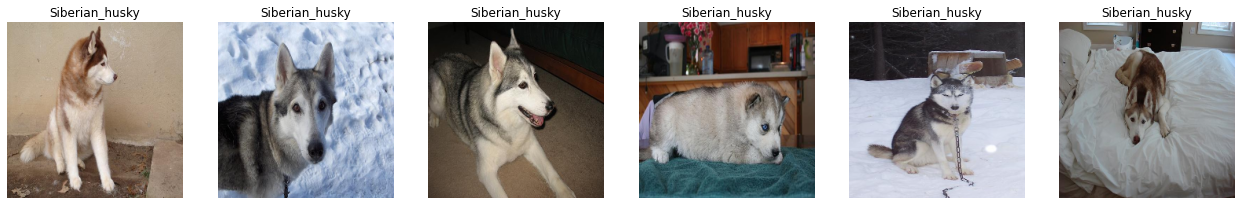

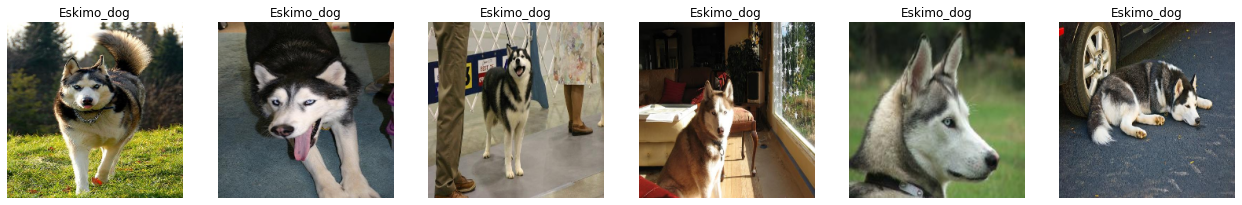

In [ ]:
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
%matplotlib inline 

def show_grid_images(image_path_list, augmentor=None, ncols=4, title=None):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        image = cv2.cvtColor(cv2.imread(image_path_list[i]), cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        if augmentor is not None:
            image = augmentor(image=image)['image']
        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(title) 
        
breed_image_list_01 = data_df[data_df['label']=='Siberian_husky']['path'].iloc[:6].tolist()
breed_image_list_02 = data_df[data_df['label']=='Eskimo_dog']['path'].iloc[:6].tolist()

show_grid_images(breed_image_list_01, ncols=6, title='Siberian_husky')
show_grid_images(breed_image_list_02, ncols=6, title='Eskimo_dog')

### EfficientNetB0 기반에서 Augmentation 기법을 변화 시키면서 모델 학습. ReduceLROnPlateau 적용. 
* 학습 데이터가 적을 경우 Augmentation이 너무 약할 경우, 과적합(Overfitting), Augmentation이 너무 강하거나 잘못 될 경우 과소적합(Underfitting)이 가능성이 있음. 
* 이전에 적용한 좌우 반전보다는 더 다양한 기법을 적용하면서 모델 학습하고, 학습데이터와 검증 데이터의 loss/metric 변화 추이 모니터링. 

In [ ]:
augmentor_heavy_01 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.2),
    A.CenterCrop(height=90, width=90, p=0.2),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.2),
    A.ColorJitter(p=0.2),
    A.OneOf(
        [A.CoarseDropout(p=1, max_holes=26), 
         A.CLAHE(p=1),
         A.Blur(blur_limit=(10, 15), p=1)
        ], p=0.3)
])


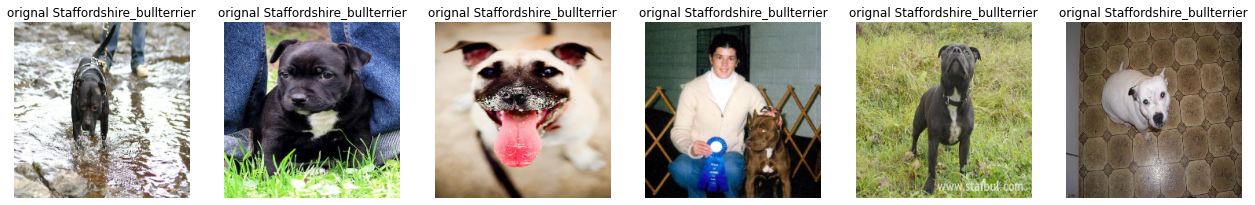

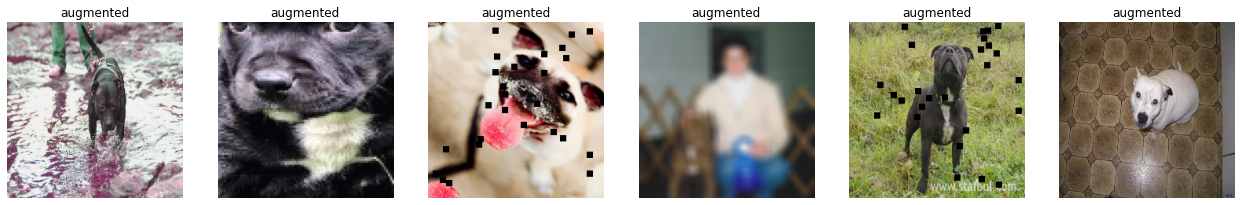

In [ ]:
breed_image_list_01 = data_df[data_df['label']=='Staffordshire_bullterrier']['path'].iloc[:6].tolist()       
show_grid_images(breed_image_list_01, augmentor=None, ncols=6, title='orignal Staffordshire_bullterrier')
show_grid_images(breed_image_list_01, augmentor=augmentor_heavy_01, ncols=6, title='augmented')

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess_input

effb0_model_aug01, effb0_history_aug01 = train_model(model_type='efficientnetb0', train_df=train_df, initial_lr=0.0001, 
                                                     augmentor=augmentor_heavy_01, input_pre_func=eff_preprocess_input)

tr_path shape: (9878,) tr_label shape: (9878, 120) val_path shape: (2470,) val_label shape: (2470, 120)
### train dataset shape: (64, 224, 224, 3)
####### efficientnetb0  생성 및 학습 수행 ########
16719872/16705208 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
154/154 [==============================] - 101s 550ms/step - loss: 4.3989 - accuracy: 0.0890 - val_loss: 2.5787 - val_accuracy: 0.4568 - lr: 1.0000e-04
Epoch 2/30
154/154 [==============================] - 83s 541ms/step - loss: 2.7486 - accuracy: 0.3634 - val_loss: 1.2487 - val_accuracy: 0.6756 - lr: 1.0000e-04
Epoch 3/30
154/154 [==============================] - 83s 535ms/step - loss: 1.8906 - accuracy: 0.5086 - val_loss: 0.9371 - val_accuracy: 0.7426 - lr: 1.0000e-04
Epoch 4/30
154/154 [==============================] - 82s 534ms/step - loss: 1.5831 - accuracy: 0.5746 - val_loss: 0.8254 - val_accuracy: 0.7632 - lr: 1.0000e-04
Epoch 5/30
154/154 [==============================] - 83s 535ms/step - loss: 1.3996 - accuracy: 0.6147 - val_loss: 0.7419 - val_accuracy: 0.7767 - lr: 1.0000e-04
Epoch 6/30
154/154 [==============================] - 83s 535ms/step - loss: 1.2724 - accuracy: 0.6473 - val_loss: 0.6938 - val_accuracy: 0.7882 - lr: 1.0000e-04
Epoch 7/30
154/154 [=======

### 학습된 모델을 이용하여 테스트 데이터로 Evaluation 및 Prediction 수행. 

In [ ]:
test_path = test_df['path'].values
test_label = pd.get_dummies(test_df['label']).values
test_classes = np.argmax(test_label, axis=1)
test_df['gt_class'] = test_classes

test_ds = Breed_Dataset(test_path, test_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, 
                        augmentor=None, shuffle=False, pre_func=eff_preprocess_input)

effb0_model_aug01.evaluate(test_ds)

NameError: ignored

In [ ]:
# 테스트 Dataset으로 개별 image들의 predict 수행. 
predict_result = effb0_model_aug01.predict(test_ds, steps=int(np.ceil(len(test_label)/BATCH_SIZE)))
predict_class = np.argmax(predict_result, axis=1)

test_df['effb0_aug01_pred_class'] = predict_class
print(test_df[test_df['gt_class'] != test_df['effb0_aug01_pred_class']]['label'].value_counts())

### 다른 Augmentation을 적용. 
* CenterCrop 제외하고 probability를 약간 변경.  

In [ ]:
augmentor_heavy_02 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.3),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.3),
    A.ColorJitter(p=0.3),
    A.OneOf(
        [A.CoarseDropout(p=0.3, max_holes=26), 
         A.CLAHE(p=0.3),
         A.Blur(blur_limit=(10, 15), p=0.3)
        ], p=0.3)
])


In [ ]:
breed_image_list_01 = data_df[data_df['label']=='Staffordshire_bullterrier']['path'].iloc[:6].tolist()       
show_grid_images(breed_image_list_01, augmentor=None, ncols=6, title='orignal Staffordshire_bullterrier')
show_grid_images(breed_image_list_01, augmentor=augmentor_heavy_02, ncols=6, title='augmented Staffordshire_bullterrier')

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess_input

effb0_model_aug02, effb0_history_aug02 = train_model(model_type='efficientnetb0', train_df=train_df, initial_lr=0.0001,
                                               augmentor=augmentor_heavy_02, input_pre_func=eff_preprocess_input)

In [ ]:
test_path = test_df['path'].values
test_label = pd.get_dummies(test_df['label']).values


test_ds = Breed_Dataset(test_path, test_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, 
                        augmentor=None, shuffle=False, pre_func=eff_preprocess_input)

effb0_model_aug02.evaluate(test_ds)

### Learning Rate Scheduler를 Ramp Up and Step Decay 방식으로 변경
* 최초는 1e-5에서 2회 Ramp up 단계를 거쳐서, Max인 1e-4까지 증가 시킴. 이후는 Step Decay 방식으로 2회 마다 learning rate를 줄임. 

In [ ]:
# learning rate scheduler에 적용할 함수 선언. 내포 함수를 사용. 
def lrfn(epoch):
    # 내포 함수인 calc_fn()에서 사용되는 파라미터. 
    LR_START = 1e-5
    LR_MAX = 1e-4
    LR_RAMPUP_EPOCHS = 2
    LR_SUSTAIN_EPOCHS = 2
    LR_STEP_DECAY = 0.75
    
    def calc_fn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//2)
        return lr
    
    # 반드시 내포 함수인 calc_fn(epoch)를 호출해야함. 
    return calc_fn(epoch)

In [ ]:
for i in range(30):
    print(lrfn(i+1))

### 기존 train_model()에 RampUp and Step Decay를 Callback으로 반영할 수 있도록 train_model_with_aug_lr()로 함수 수정.
* Learning Rate Scheduler등의 Callback 객체를 인자로 입력 받을 수 있도록 함수 수정. 

In [ ]:
N_EPOCHS = 30
BATCH_SIZE = 64
IMAGE_SIZE = 224

def train_model_with_aug_lr(model_type, train_df, initial_lr=0.001, augmentor=None, callbacks_list=None, input_pre_func=None):
    
    tr_path, val_path, tr_label, val_label = get_train_valid(train_df, valid_size=0.2, random_state=2021)
    
    tr_ds = Breed_Dataset(tr_path, tr_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, 
                          augmentor=augmentor, shuffle=True, pre_func=input_pre_func)
    val_ds = Breed_Dataset(val_path, val_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, 
                          augmentor=None, shuffle=False, pre_func=input_pre_func)

    # model_type인자로 들어온 모델 생성. optimizer Adam적용. 
    print('#######', model_type, ' 생성 및 학습 수행 ########')
    model = create_model(model_type=model_type)
    model.compile(optimizer=Adam(lr=initial_lr), loss='categorical_crossentropy', metrics=['accuracy'])
    # learning rate scheduler와 early stopping 을 함수 인자로 입력 받음. 
    history = model.fit(tr_ds, epochs=N_EPOCHS, steps_per_epoch=tr_path.shape[0]//BATCH_SIZE, 
                   validation_data=val_ds, validation_steps=val_path.shape[0]//BATCH_SIZE,
                   callbacks=(callbacks_list), verbose=1)
    
    return model, history

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess_input
import tensorflow as tf

# Learning Rate Scheduler(Ramp up and step down decay) 와 Early Stopping callback 생성. 
lr_cb = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
ely_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
# train_model에 인자로 넣을 Callback 객체의 리스트 생성. 
callbacks_list = [lr_cb, ely_cb]

augmentor_heavy_01 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.2),
    A.CenterCrop(height=90, width=90, p=0.2),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.2),
    A.ColorJitter(p=0.2),
    A.OneOf(
        [A.CoarseDropout(p=1, max_holes=26), 
         A.CLAHE(p=1),
         A.Blur(blur_limit=(10, 15), p=1)
        ], p=0.3)
])

augmentor_heavy_02 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.3),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.3),
    A.ColorJitter(p=0.3),
    A.OneOf(
        [A.CoarseDropout(p=0.3, max_holes=26), 
         A.CLAHE(p=0.3),
         A.Blur(blur_limit=(10, 15), p=0.3)
        ], p=0.3)
])

# augmentor_heavy_01을 ramp up and step decay 적용. 
effb0_model_lr01, effb0_history_lr01 = train_model_with_aug_lr(model_type='efficientnetb0', train_df=train_df, initial_lr=0.0001, 
                                               augmentor=augmentor_heavy_01, callbacks_list=callbacks_list, input_pre_func=eff_preprocess_input)

In [ ]:
test_path = test_df['path'].values
test_label = pd.get_dummies(test_df['label']).values

test_ds = Breed_Dataset(test_path, test_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, 
                        augmentor=None, shuffle=False, pre_func=eff_preprocess_input)

effb0_model_lr01.evaluate(test_ds)

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess_input
import tensorflow as tf

# augmentor_heavy_02를 ramp up and step decay 적용. 
effb0_model_lr02, effb0_history_lr02 = train_model_with_aug_lr(model_type='efficientnetb0', train_df=train_df, initial_lr=0.0001, 
                                               augmentor=augmentor_heavy_02, callbacks_list=callbacks_list, input_pre_func=eff_preprocess_input)

In [ ]:
test_ds = Breed_Dataset(test_path, test_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, 
                        augmentor=None, shuffle=False, pre_func=eff_preprocess_input)

effb0_model_lr02.evaluate(test_ds)


### Pretrained 모델의 Fine Tuning 적용. 
* Fine tuning으로 1차 dense layer 부터 학습 적용, 2차 전체 Layer 학습 적용. 
* EfficientNet의 경우는 Batch Normalization은 학습하지 않도록 설정. 

In [ ]:
model_imsi =create_model(model_type='efficientnetb0')
model_imsi.summary()

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

N_EPOCHS = 30
BATCH_SIZE = 64
IMAGE_SIZE = 224

def train_model_with_ft(model_type, train_df, initial_lr=0.0001, augmentor=None, callbacks_list=None, input_pre_func=None):
    
    tr_path, val_path, tr_label, val_label = get_train_valid(train_df, valid_size=0.2, random_state=2021)

    tr_ds = Breed_Dataset(tr_path, tr_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, 
                        augmentor=augmentor, shuffle=True, pre_func=input_pre_func)
    val_ds = Breed_Dataset(val_path, val_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, 
                        augmentor=None, shuffle=False, pre_func=input_pre_func)

    # model_type인자로 들어온 모델 생성. optimizer Adam적용. 
    print('#######', model_type, ' 생성 및 학습 수행 ########')
    model = create_model(model_type=model_type)
    
    # Feature Extractor layer들을 모두 Freeze
    for layer in model.layers[:-4]:
        layer.trainable = False
    
    model.compile(optimizer=Adam(lr=initial_lr), loss='categorical_crossentropy', metrics=['accuracy'])
    
    #10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
    ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
    #cosine_decay = tf.keras.experimental.CosineDecay(initial_learning_rate=0.001, decay_steps=300)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
    
    ### Feature Extractor layer들은 학습하지 않고 Dense Layer만 일차 학습. 
    print('##### Feature Extractor freeze후 Dense layer 학습 시작 ##### ')
    history = model.fit(tr_ds, epochs=15, steps_per_epoch=int(np.ceil(tr_path.shape[0]/BATCH_SIZE)), 
                  validation_data=val_ds, validation_steps=int(np.ceil(val_path.shape[0]/BATCH_SIZE)),
                  callbacks=(callbacks_list), verbose=1)
    # efficientNet의 일부만 trainable 가능하게 설정. 특히 BatchNormalization layer는 trainable False로 유지. 
    # https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
    #for layer in model.layers[-20:]:
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    
    print('##### 전체 Layer Unfreeze 후 학습 시작 ##### ')
    history = model.fit(tr_ds, epochs=25, steps_per_epoch=int(np.ceil(tr_path.shape[0]/BATCH_SIZE)), 
                  validation_data=val_ds, validation_steps=int(np.ceil(val_path.shape[0]/BATCH_SIZE)),
                  callbacks=(callbacks_list), verbose=1)

    return model, history

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess_input
import tensorflow as tf

# learning rate scheduler에 적용할 함수 선언. 내포 함수를 사용. 
def lrfn(epoch):
    # 내포 함수인 calc_fn()에서 사용되는 파라미터. 
    LR_START = 1e-5
    LR_MAX = 1e-4
    LR_RAMPUP_EPOCHS = 2
    LR_SUSTAIN_EPOCHS = 1
    LR_STEP_DECAY = 0.75
    
    def calc_fn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//2)
        return lr
    
    # 반드시 내포 함수인 calc_fn(epoch)를 호출해야함. 
    return calc_fn(epoch)

# Learning Rate Scheduler(Ramp up and step down decay) 와 Early Stopping callback 생성. 
lr_cb = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
ely_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
# train_model에 인자로 넣을 Callback 객체의 리스트 생성. 
callbacks_list = [lr_cb, ely_cb]


augmentor_light_01 = A.Compose([
    A.HorizontalFlip(p=0.5),
])

augmentor_light_02 = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.ShiftScaleRotate(scale_limit=(0.7, 0.9), p=0.2, rotate_limit=30),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.2),
    A.ColorJitter(p=0.2)
])

augmentor_heavy_01 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.2),
    A.CenterCrop(height=90, width=90, p=0.2),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.2),
    A.ColorJitter(p=0.2),
    A.OneOf(
        [A.CoarseDropout(p=1, max_holes=26), 
         A.CLAHE(p=1),
         A.Blur(blur_limit=(10, 15), p=1)
        ], p=0.3)
])

augmentor_heavy_02 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.3),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.3),
    A.ColorJitter(p=0.3),
    A.OneOf(
        [A.CoarseDropout(p=0.3, max_holes=26), 
         A.CLAHE(p=0.3),
         A.Blur(blur_limit=(10, 15), p=0.3)
        ], p=0.3)
])

In [ ]:
effb0_model_ft01, effb0_history_ft01 = train_model_with_ft(model_type='efficientnetb0', train_df=train_df, initial_lr=0.0001, 
                                            augmentor=augmentor_heavy_01, callbacks_list=callbacks_list, input_pre_func=eff_preprocess_input)

In [ ]:
test_path = test_df['path'].values
test_label = pd.get_dummies(test_df['label']).values

test_ds = Breed_Dataset(test_path, test_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, 
                        augmentor=None, shuffle=False, pre_func=eff_preprocess_input)

effb0_model_ft01.evaluate(test_ds)

### lighter한 Augmentation 적용. 

In [ ]:
effb0_model_ft02, effb0_history_ft02 = train_model_with_ft(model_type='efficientnetb0', train_df=train_df, initial_lr=0.0001, 
                                            augmentor=augmentor_light_02, callbacks_list=callbacks_list, input_pre_func=eff_preprocess_input)

In [ ]:
test_ds = Breed_Dataset(test_path, test_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, 
                        augmentor=None, shuffle=False, pre_func=eff_preprocess_input)

effb0_model_ft02.evaluate(test_ds)

### 지금까지 변경 테스트한 여러 환경들을 손쉽게 테스트 해볼 수 있도록 함수 재구성. 
* Config 클래스를 만들어서 여기에 테스트에 필요한 인자들을 모두 설정 할 수 있도록 함. 
* train_model() 인자로 Config 를 입력 받아서 이를 기반으로 학습을 수행할 수 있도록 변경. 

In [ ]:
class Config:
    MODEL_TYPE = 'effcientnetb0'
    IMAGE_SIZE = 224
    BATCH_SIZE = 64
    N_EPOCHS = 30 # fine tuning이 아닐 경우 전체 수행 epoch 횟수
    IS_FINE_TUNING = False # Fine Tuning 여부
    FIRST_EPOCHS = 15 # fine tuning 일 경우 첫번째 epoch 횟수
    SECOND_EPOCHS = 25 # fine tuning 일 경우 두번째 epoch 횟수
    FIRST_CALLBACKS = None # 모델 train시 적용될 callback 객체들의 List
    SECOND_CALLBACKS = None # 만일 Fine tuning 시 첫번째 학습과 두번째 학습의 Learning rate scheduler가 서로 다를 경우 사용. 
    AUGMENTOR = None
    PRE_FUNC = None
    INITIAL_LR = 0.0001 # Optimizer에 적용될 최초 Learning rate
    DEBUG = False

### 아래는 기존에 사용한 라이브러리 함수를 그대로 가져온 것임

In [ ]:
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

from tensorflow.keras.applications import Xception, ResNet50V2, EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
from tensorflow.keras.applications import MobileNet
import tensorflow as tf

# dog breed 종류는 120가지
N_CLASSES = 120

def create_model(model_type='xception', in_shape=(224, 224, 3), n_classes=120):
    input_tensor = Input(shape=in_shape)

    if model_type == 'resnet50v2':
        base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'xception':
        base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'efficientnetb0':
        base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'efficientnetb1':
        base_model = tf.keras.applications.EfficientNetB1(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'efficientnetb2':
        base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'efficientnetb3':
        base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet', input_tensor=input_tensor)
        
    x = base_model.output  
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)    
    preds = Dense(units=n_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=preds)
    
    return model

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
import sklearn 
import cv2

import albumentations as A

IMAGE_DIR = '/kaggle/working/Images'

def make_dogbreed_dataframe(image_dir=IMAGE_DIR):
    paths = []
    label_gubuns = []
    for dirname, _, filenames in os.walk(image_dir):
        for filename in filenames:
            # 이미지 파일이 아닌 파일도 해당 디렉토리에 있음.
            if '.jpg' in filename:
                # 파일의 절대 경로를 file_path 변수에 할당. 
                file_path = dirname+'/'+ filename
                paths.append(file_path)
                # 이미지 파일의 절대 경로에서 레이블명 생성을 위한 1차 추출. '/'로 분할하여 파일 바로 위 서브디렉토리 이름 가져옴.  
                start_pos = file_path.find('/', 20)
                end_pos = file_path.rfind('/')
                imsi_breed = file_path[start_pos+1:end_pos]
                # 1차 추출된 데이터를 기반으로 '-' 이후 데이터가 레이블 값임. 
                breed = imsi_breed[imsi_breed.find('-')+1:]
                #print(start_pos, end_pos, imsi_breed)
                label_gubuns.append(breed)

    data_df = pd.DataFrame({'path':paths, 'label':label_gubuns})
    return data_df

# 학습과 검증 데이터용 numpy array 분리. 
def get_train_valid(train_df, valid_size=0.2, random_state=2021):
    train_path = train_df['path'].values
    train_label = pd.get_dummies(train_df['label']).values
    
    tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size=valid_size, random_state=random_state)
    print('tr_path shape:', tr_path.shape, 'tr_label shape:', tr_label.shape, 'val_path shape:', val_path.shape, 'val_label shape:', val_label.shape)
    return tr_path, val_path, tr_label, val_label


# 입력 인자 image_filenames, labels는 모두 numpy array로 들어옴. 
class Breed_Dataset(Sequence):
    def __init__(self, image_filenames, labels, image_size=224, batch_size=64, 
                 augmentor=None, shuffle=False, pre_func=None):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.labels = labels
        self.image_size = image_size
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.pre_func = pre_func
        # train data의 경우 
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다. 
        return int(np.ceil(len(self.labels) / self.batch_size))
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((image_name_batch.shape[0], self.image_size, self.image_size, 3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
            #crop 시 잘린 이미지가 원본 이미지와 다르게 되므로 augmentation 적용 후 resize() 적용. 
            image = cv2.resize(image, (self.image_size, self.image_size))
            # 만일 preprocessing_input이 pre_func인자로 들어오면 이를 이용하여 scaling 적용. 
            if self.pre_func is not None:
                image = self.pre_func(image)
                
            image_batch[image_index] = image
        
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 전체 image 파일의 위치와 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass
        
        
augmentor_light = A.Compose([
    A.HorizontalFlip(p=0.5),
])

### train_model 함수를 Config 클래스 값을 인자로 입력 받을 수 있도록 변경. 

In [ ]:
def train_model(train_df, config=Config):
    # 학습과 검증 데이터 이미지/레이블로 분리하고 학습/검증 Dataset 생성. 
    tr_path, val_path, tr_label, val_label = get_train_valid(train_df, valid_size=0.2, random_state=2021)
    
    tr_ds = Breed_Dataset(tr_path, tr_label, image_size=config.IMAGE_SIZE, batch_size=config.BATCH_SIZE, 
                          augmentor=config.AUGMENTOR, shuffle=True, pre_func=config.PRE_FUNC)
    val_ds = Breed_Dataset(val_path, val_label, image_size=config.IMAGE_SIZE, batch_size=config.BATCH_SIZE, 
                          augmentor=None, shuffle=False, pre_func=config.PRE_FUNC)
    if config.DEBUG:
        tr_image_batch = next(iter(tr_ds))[0]
        val_image_batch = next(iter(val_ds))[0]
        print(tr_image_batch.shape, val_image_batch.shape)
        print(tr_image_batch[0], val_image_batch[0])
        
    # model_type인자로 들어온 모델 생성. optimizer Adam적용. 
    print('#######', config.MODEL_TYPE, ' 생성 및 학습 수행 ########')
    model = create_model(model_type=config.MODEL_TYPE, in_shape=(config.IMAGE_SIZE, config.IMAGE_SIZE, 3), n_classes=120)
    model.compile(optimizer=Adam(lr=config.INITIAL_LR), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # 만일 Fine tuning 일 경우 아래 로직 적용. 
    if config.IS_FINE_TUNING:
        print('####### Fine tuning 학습을 시작합니다. ########')
        # 첫번째 Fine Tuning. Feature Extractor를 제외한 classification layer를 학습.(Feature Extractor layer들을 trainable=False 설정)
        for layer in model.layers[:-4]:
            layer.trainable = False
        
        print('####### Classification Layer들의 학습을 시작합니다. ########')
        history = model.fit(tr_ds, epochs=config.FIRST_EPOCHS, steps_per_epoch=int(np.ceil(tr_path.shape[0]/config.BATCH_SIZE)), 
                           validation_data=val_ds, validation_steps=int(np.ceil(val_path.shape[0]/config.BATCH_SIZE)),
                           callbacks=(config.FIRST_CALLBACKS), verbose=1)
        
        # 두번째, 전체 Layer를 학습. 전체 layer를 trainable=True로 수정. Batch Normalization layer는 fine tuning시 계속 trainable=False 설정. 
        for layer in model.layers:
            if not isinstance(layer, layers.BatchNormalization):
                layer.trainable = True
        
        print('####### 전체 Layer들의 학습을 시작합니다. ########')
        history = model.fit(tr_ds, epochs=config.SECOND_EPOCHS, steps_per_epoch=int(np.ceil(tr_path.shape[0]/config.BATCH_SIZE)), 
                           validation_data=val_ds, validation_steps=int(np.ceil(val_path.shape[0]/config.BATCH_SIZE)),
                           callbacks=(config.SECOND_CALLBACKS), verbose=1)
    
    # Fine Tuning이 아닐 경우 
    else:
        print('####### 학습을 시작합니다. ########')
        history = model.fit(tr_ds, epochs=config.N_EPOCHS, steps_per_epoch=int(np.ceil(tr_path.shape[0]/config.BATCH_SIZE)), 
                       validation_data=val_ds, validation_steps=int(np.ceil(val_path.shape[0]/config.BATCH_SIZE)),
                       callbacks=(config.FIRST_CALLBACKS), verbose=1)
        
    return model, history


### EfficientNetB1 모델 학습 및 성능 평가
* Config 클래스의 내부 변수값으로 할당 될 수 있도록 Learning Rate Scheduler에 적용될 함수, Callback 객체, Augmentation객체들을 생성
* EfficientNetB1의 경우 240x240 이미지 크기로 최적화 되었으므로 이에 맞게 Config 값 설정. 

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess_input
import tensorflow as tf

# learning rate scheduler에 적용할 함수 선언. 
def lrfn_01(epoch):
    LR_START = 1e-5
    LR_MAX = 1e-4
    LR_RAMPUP_EPOCHS = 2
    LR_SUSTAIN_EPOCHS = 1
    LR_STEP_DECAY = 0.75
    
    def calc_fn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//2)
        return lr
    
    return calc_fn(epoch)

def lrfn_02(epoch):
    LR_START = 1e-6
    LR_MAX = 2e-5
    LR_RAMPUP_EPOCHS = 2
    LR_SUSTAIN_EPOCHS = 1
    LR_STEP_DECAY = 0.75
    
    def calc_fn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//2)
        return lr
    
    return calc_fn(epoch)

# Config에 입력할 callback 생성. 
lr01_cb = tf.keras.callbacks.LearningRateScheduler(lrfn_01, verbose=1)
lr02_cb = tf.keras.callbacks.LearningRateScheduler(lrfn_02, verbose=1)
ely_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

# Augmentor 생성. 

augmentor_light_02 = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.ShiftScaleRotate(scale_limit=(0.7, 0.9), p=0.2, rotate_limit=30),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.2),
    A.ColorJitter(p=0.2)
])

# Config 생성. 
class Config:
    MODEL_TYPE = 'efficientnetb1'
    IMAGE_SIZE = 240
    BATCH_SIZE = 64
    N_EPOCHS = 30 # fine tuning이 아닐 경우 전체 수행 epoch 횟수
    IS_FINE_TUNING = True
    FIRST_EPOCHS = 15 # fine tuning 일 경우 첫번째 epoch 횟수
    SECOND_EPOCHS = 15 # fine tuning 일 경우 두번째 epoch 횟수
    FIRST_CALLBACKS = [lr01_cb, ely_cb] #모델 train시 적용될 callback 객체 리스트
    SECOND_CALLBACKS = [lr02_cb, ely_cb] #만일 Fine tuning 시 첫번째 학습과 두번째 학습의 Learning rate scheduler가 서로 다를 경우 사용. 
    AUGMENTOR = augmentor_light_02
    PRE_FUNC = eff_preprocess_input
    INITIAL_LR = 0.0001
    DEBUG = False

In [ ]:
# EfficientNetB1 모델 학습. 
eff1_model, history = train_model(train_df, config=Config)

In [ ]:
def evaluate_model(model, test_df, config=Config):
    test_path = test_df['path'].values
    test_label = pd.get_dummies(test_df['label']).values
    test_ds = Breed_Dataset(test_path, test_label, image_size=config.IMAGE_SIZE, batch_size=config.BATCH_SIZE, 
                        augmentor=None, shuffle=False, pre_func=config.PRE_FUNC)

    evaluation_result = model.evaluate(test_ds)
    print('evaluation_result:', evaluation_result)
    
    return model, evaluation_result

model, evaluation_result = evaluate_model(model=eff1_model, test_df=test_df, config=Config)
    